<a href="https://colab.research.google.com/github/dgalassi99/quant-trading-self-study/blob/main/02_backtesting_risk_management/W5_backtrader_%26_bt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Practicing Backtesting Libraries

## Backtrader

### Replicating Quickstart to Learn

#### Importing Libraries

In [4]:
!pip install backtrader

In [5]:
#importing the library with alias bt
import backtrader as bt
#importing otehr libraties
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import yfinance as yf
import os.path
import sys

#DATA saved locally for testing to limit yf API usage
from google.colab import drive
import os
import pandas as pd
drive.mount('/content/drive')
path = "/content/drive/My Drive/QUANT/DATA/"
print("Files in project folder:", os.listdir(path))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Files in project folder: ['btc_1d_data_2018_to_2025.csv', 'btc_1h_data_2018_to_2025.csv']


#### Basic SetUp

In [6]:
#initiating the Cerebro class
cerebro = bt.Cerebro()
#setting the cash we have
cerebro.broker.setcash(500000)
print('Starting Value: %.2f' % cerebro.broker.getvalue())
#run the backtest
cerebro.run()
print('Final Value: %.2f' % cerebro.broker.getvalue())

Starting Value: 500000.00
Final Value: 500000.00


#### Adding Data

In [7]:
#initiating the Cerebro class
cerebro = bt.Cerebro()

data =  pd.read_csv(path + 'btc_1d_data_2018_to_2025.csv')[['Open time', 'Open', 'High', 'Low', 'Close', 'Volume']]
data['Open time'] = pd.to_datetime(data['Open time'])
data.set_index('Open time', inplace=True)
data.rename(columns={
    'Open': 'open',
    'High': 'high',
    'Low': 'low',
    'Close': 'close',
    'Volume': 'volume'
}, inplace=True)
data = bt.feeds.PandasData(dataname=data)
cerebro.adddata(data)


#setting the cash we have
cerebro.broker.setcash(500000)
print('Starting Value: %.2f' % cerebro.broker.getvalue())
#run the backtest
cerebro.run()
print('Final Value: %.2f' % cerebro.broker.getvalue())

Starting Value: 500000.00
Final Value: 500000.00


#### Adding a Strategy

In [8]:
#creating a class for the strategy
class TestStrategy(bt.Strategy):

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close

    def log(self, txt, dt=None):
        ''' Logging function for this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print(f'{dt} {txt}')

    def next(self):
        # Simply log the closing price of the series from the reference
        self.log(f'Close Price, {round(self.dataclose[0],2)}')
        #if closing prices are decresing two consecutive days -> buy
        if self.dataclose[0] < self.dataclose[-1] and self.dataclose[-1] < self.dataclose[-2]:
          self.log(f'BUY CREATED {round(self.dataclose[0],2)}')
          self.buy()

#initiating the Cerebro class
cerebro = bt.Cerebro()

#add the strategy to cerebrp
cerebro.addstrategy(TestStrategy)

data =  pd.read_csv(path + 'btc_1d_data_2018_to_2025.csv')[['Open time', 'Open', 'High', 'Low', 'Close', 'Volume']]
data['Open time'] = pd.to_datetime(data['Open time'])
data.set_index('Open time', inplace=True)
data.rename(columns={
    'Open': 'open',
    'High': 'high',
    'Low': 'low',
    'Close': 'close',
    'Volume': 'volume'
}, inplace=True)
data = bt.feeds.PandasData(dataname=data)
#add data to cerebro
cerebro.adddata(data)


#setting the cash we have
cerebro.broker.setcash(500000)
print('Starting Value: %.2f' % cerebro.broker.getvalue())
#run the backtest
cerebro.run()
print('Final Value: %.2f' % cerebro.broker.getvalue())

Starting Value: 500000.00
2018-01-01 Close Price, 13380.0
2018-01-02 Close Price, 14675.11
2018-01-03 Close Price, 14919.51
2018-01-04 Close Price, 15059.54
2018-01-05 Close Price, 16960.39
2018-01-06 Close Price, 17069.79
2018-01-07 Close Price, 16150.03
2018-01-08 Close Price, 14902.54
2018-01-08 BUY CREATED 14902.54
2018-01-09 Close Price, 14400.0
2018-01-09 BUY CREATED 14400.0
2018-01-10 Close Price, 14907.09
2018-01-11 Close Price, 13238.78
2018-01-12 Close Price, 13740.01
2018-01-13 Close Price, 14210.0
2018-01-14 Close Price, 13474.99
2018-01-15 Close Price, 13539.93
2018-01-16 Close Price, 10900.0
2018-01-17 Close Price, 10988.79
2018-01-18 Close Price, 10961.97
2018-01-19 Close Price, 11474.98
2018-01-20 Close Price, 12799.94
2018-01-21 Close Price, 11530.0
2018-01-22 Close Price, 10760.05
2018-01-22 BUY CREATED 10760.05
2018-01-23 Close Price, 10799.18
2018-01-24 Close Price, 11349.99
2018-01-25 Close Price, 11175.27
2018-01-26 Close Price, 11089.0
2018-01-26 BUY CREATED 1108

In [9]:
#creating a class for the strategy
class TestStrategy(bt.Strategy):

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close
        # to keep track of orders
        self.order = None

    def log(self, txt, dt=None):
        ''' Logging function for this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print(f'{dt} {txt}')

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(f'BUY EXECUTED, {round(order.executed.price,2)}')
            elif order.issell():
                self.log(f'SELL EXECUTED, {round(order.executed.price,2)}')
            self.bar_executed = len(self)
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Set no order
        self.order = None

    def next(self):
        # Simply log the closing price of the series from the reference
        self.log(f'Close Price, {round(self.dataclose[0],2)}')

        #check if an order is pending... if true do not send a 2nd order
        if self.order:
            return
        #check if we are in the marker
        if not self.position:
            #we might buy if
            if self.dataclose[0] < self.dataclose[-1] and self.dataclose[-1] < self.dataclose[-2]:
              self.log(f'BUY CREATED {round(self.dataclose[0],2)}')
              self.order = self.buy()
        else:
          #if already in the market we might sell if:
          if len(self) >= (self.bar_executed + 5):
            self.log(f'SELL CREATED {round(self.dataclose[0],2)}')
            self.order = self.sell()



#initiating the Cerebro class
cerebro = bt.Cerebro()

#add the strategy to cerebrp
cerebro.addstrategy(TestStrategy)

#getting data via yf API
data = yf.download('SPY',start='2022-01-01',end='2025-01-01')
#remove the multi-ndexing of the dataframe
data = data.droplevel(level=1,axis=1)
#load into backtrader the pd.dataframe
data = bt.feeds.PandasData(dataname=data)

#add data to cerebro
cerebro.adddata(data)


#setting the cash we have
cerebro.broker.setcash(500000)
print('Starting Value: %.2f' % cerebro.broker.getvalue())
#run the backtest
cerebro.run()
print('Final Value: %.2f' % cerebro.broker.getvalue())

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['SPY']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Starting Value: 500000.00
Final Value: 500000.00


#### Adding Commissions

In [10]:
#creating a class for the strategy
class TestStrategy(bt.Strategy):

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close
        # to keep track of orders
        self.order = None

    def log(self, txt, dt=None):
        ''' Logging function for this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print(f'{dt} {txt}')

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(f'BUY EXECUTED, Price: {round(order.executed.price,2)}, Cost: {round(order.executed.value,2)}, Comm: {round(order.executed.comm,2)}')
            elif order.issell():
                self.log(f'SELL EXECUTED, Price: {round(order.executed.price,2)}, Cost: {round(order.executed.value,2)}, Comm: {round(order.executed.comm,2)}')
            self.bar_executed = len(self)
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Set no order
        self.order = None

    def notify_trade(self,trade):
      if not trade.isclosed:
        return
      self.log(f'OPERATION PROFIT, GROSS {round(trade.pnl,2)}, NET {round(trade.pnlcomm,2)}')

    def next(self):
        # Simply log the closing price of the series from the reference
        self.log(f'Close Price, {round(self.dataclose[0],2)}')

        #check if an order is pending... if true do not send a 2nd order
        if self.order:
            return
        #check if we are in the marker
        if not self.position:
            #we might buy if
            if self.dataclose[0] < self.dataclose[-1] and self.dataclose[-1] < self.dataclose[-2]:
              self.log(f'BUY CREATED {round(self.dataclose[0],2)}')
              self.order = self.buy()
        else:
          #if already in the market we might sell if:
          if len(self) >= (self.bar_executed + 5):
            self.log(f'SELL CREATED {round(self.dataclose[0],2)}')
            self.order = self.sell()



#initiating the Cerebro class
cerebro = bt.Cerebro()

#add the strategy to cerebrp
cerebro.addstrategy(TestStrategy)

data =  pd.read_csv(path + 'btc_1d_data_2018_to_2025.csv')[['Open time', 'Open', 'High', 'Low', 'Close', 'Volume']]
data['Open time'] = pd.to_datetime(data['Open time'])
data.set_index('Open time', inplace=True)
data.rename(columns={
    'Open': 'open',
    'High': 'high',
    'Low': 'low',
    'Close': 'close',
    'Volume': 'volume'
}, inplace=True)
data = bt.feeds.PandasData(dataname=data)

#add data to cerebro
cerebro.adddata(data)

#adding 0.1% commission
cerebro.broker.setcommission(commission=0.001)


#setting the cash we have
cerebro.broker.setcash(500000)
print('Starting Value: %.2f' % cerebro.broker.getvalue())
#run the backtest
cerebro.run()
print('Final Value: %.2f' % cerebro.broker.getvalue())

Starting Value: 500000.00
2018-01-01 Close Price, 13380.0
2018-01-02 Close Price, 14675.11
2018-01-03 Close Price, 14919.51
2018-01-04 Close Price, 15059.54
2018-01-05 Close Price, 16960.39
2018-01-06 Close Price, 17069.79
2018-01-07 Close Price, 16150.03
2018-01-08 Close Price, 14902.54
2018-01-08 BUY CREATED 14902.54
2018-01-09 BUY EXECUTED, Price: 14902.54, Cost: 14902.54, Comm: 14.9
2018-01-09 Close Price, 14400.0
2018-01-10 Close Price, 14907.09
2018-01-11 Close Price, 13238.78
2018-01-12 Close Price, 13740.01
2018-01-13 Close Price, 14210.0
2018-01-14 Close Price, 13474.99
2018-01-14 SELL CREATED 13474.99
2018-01-15 SELL EXECUTED, Price: 13477.98, Cost: 14902.54, Comm: 13.48
2018-01-15 OPERATION PROFIT, GROSS -1424.56, NET -1452.94
2018-01-15 Close Price, 13539.93
2018-01-16 Close Price, 10900.0
2018-01-17 Close Price, 10988.79
2018-01-18 Close Price, 10961.97
2018-01-19 Close Price, 11474.98
2018-01-20 Close Price, 12799.94
2018-01-21 Close Price, 11530.0
2018-01-22 Close Price,

#### Adding Parameters

In [11]:
#creating a class for the strategy
class TestStrategy(bt.Strategy):
    params = (('exitbars',6),)

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close
        # to keep track of orders
        self.order = None
        self.buyprice = None
        self.buycomm = None

    def log(self, txt, dt=None):
        ''' Logging function for this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print(f'{dt} {txt}')

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(f'BUY EXECUTED, Price: {round(order.executed.price,2)}, Cost: {round(order.executed.value,2)}, Comm: {round(order.executed.comm,2)}')
            elif order.issell():
                self.log(f'SELL EXECUTED, Price: {round(order.executed.price,2)}, Cost: {round(order.executed.value,2)}, Comm: {round(order.executed.comm,2)}')
            self.bar_executed = len(self)
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Set no order
        self.order = None

    def notify_trade(self,trade):
      if not trade.isclosed:
        return
      self.log(f'OPERATION PROFIT, GROSS {round(trade.pnl,2)}, NET {round(trade.pnlcomm,2)}')

    def next(self):
        # Simply log the closing price of the series from the reference
        self.log(f'Close Price, {round(self.dataclose[0],2)}')

        #check if an order is pending... if true do not send a 2nd order
        if self.order:
            return
        #check if we are in the marker
        if not self.position:
            #we might buy if
            if self.dataclose[0] < self.dataclose[-1] and self.dataclose[-1] < self.dataclose[-2]:
              self.log(f'BUY CREATED {round(self.dataclose[0],2)}')
              self.order = self.buy()
        else:
          #if already in the market we might sell if:
          if len(self) >= (self.bar_executed + 5):
            self.log(f'SELL CREATED {round(self.dataclose[0],2)}')
            self.order = self.sell()



#initiating the Cerebro class
cerebro = bt.Cerebro()

#add the strategy to cerebrp
cerebro.addstrategy(TestStrategy)

data =  pd.read_csv(path + 'btc_1d_data_2018_to_2025.csv')[['Open time', 'Open', 'High', 'Low', 'Close', 'Volume']]
data['Open time'] = pd.to_datetime(data['Open time'])
data.set_index('Open time', inplace=True)
data.rename(columns={
    'Open': 'open',
    'High': 'high',
    'Low': 'low',
    'Close': 'close',
    'Volume': 'volume'
}, inplace=True)
data = bt.feeds.PandasData(dataname=data)
#add data to cerebro
cerebro.adddata(data)

#adding 0.1% commission
cerebro.broker.setcommission(commission=0.001)


#setting the cash we have
cerebro.broker.setcash(500000)
print('Starting Value: %.2f' % cerebro.broker.getvalue())
#run the backtest
cerebro.run()
print('Final Value: %.2f' % cerebro.broker.getvalue())

Starting Value: 500000.00
2018-01-01 Close Price, 13380.0
2018-01-02 Close Price, 14675.11
2018-01-03 Close Price, 14919.51
2018-01-04 Close Price, 15059.54
2018-01-05 Close Price, 16960.39
2018-01-06 Close Price, 17069.79
2018-01-07 Close Price, 16150.03
2018-01-08 Close Price, 14902.54
2018-01-08 BUY CREATED 14902.54
2018-01-09 BUY EXECUTED, Price: 14902.54, Cost: 14902.54, Comm: 14.9
2018-01-09 Close Price, 14400.0
2018-01-10 Close Price, 14907.09
2018-01-11 Close Price, 13238.78
2018-01-12 Close Price, 13740.01
2018-01-13 Close Price, 14210.0
2018-01-14 Close Price, 13474.99
2018-01-14 SELL CREATED 13474.99
2018-01-15 SELL EXECUTED, Price: 13477.98, Cost: 14902.54, Comm: 13.48
2018-01-15 OPERATION PROFIT, GROSS -1424.56, NET -1452.94
2018-01-15 Close Price, 13539.93
2018-01-16 Close Price, 10900.0
2018-01-17 Close Price, 10988.79
2018-01-18 Close Price, 10961.97
2018-01-19 Close Price, 11474.98
2018-01-20 Close Price, 12799.94
2018-01-21 Close Price, 11530.0
2018-01-22 Close Price,

#### Adding an Indicator

- Buy “AtMarket” if the close is greater than the Average

- If in the market, sell if the close is smaller than the Average

- Only 1 active operation is allowed in the market

In [12]:
#creating a class for the strategy
class TestStrategy(bt.Strategy):
    params = (('maperiod',15),)

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close
        # to keep track of orders
        self.order = None
        self.buyprice = None
        self.buycomm = None
        #MA indicator
        self.sma = bt.indicators.SimpleMovingAverage(self.datas[0],period=self.params.maperiod)

    def log(self, txt, dt=None):
        ''' Logging function for this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print(f'{dt} {txt}')

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(f'BUY EXECUTED, Price: {round(order.executed.price,2)}, Cost: {round(order.executed.value,2)}, Comm: {round(order.executed.comm,2)}')
            elif order.issell():
                self.log(f'SELL EXECUTED, Price: {round(order.executed.price,2)}, Cost: {round(order.executed.value,2)}, Comm: {round(order.executed.comm,2)}')
            self.bar_executed = len(self)
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Set no order
        self.order = None

    def notify_trade(self,trade):
      if not trade.isclosed:
        return
      self.log(f'OPERATION PROFIT, GROSS {round(trade.pnl,2)}, NET {round(trade.pnlcomm,2)}')

    def next(self):
        # Simply log the closing price of the series from the reference
        self.log(f'Close Price, {round(self.dataclose[0],2)}')

        #check if an order is pending... if true do not send a 2nd order
        if self.order:
            return
        #check if we are in the marker
        if not self.position:
            #we might buy if
            if self.dataclose[0] < self.dataclose[-1] and self.dataclose[-1] < self.dataclose[-2]:
              self.log(f'BUY CREATED {round(self.dataclose[0],2)}')
              self.order = self.buy()
        else:
          #if already in the market we might sell if:
          if len(self) >= (self.bar_executed + 5):
            self.log(f'SELL CREATED {round(self.dataclose[0],2)}')
            self.order = self.sell()



#initiating the Cerebro class
cerebro = bt.Cerebro()

#add the strategy to cerebrp
cerebro.addstrategy(TestStrategy)
data =  pd.read_csv(path + 'btc_1d_data_2018_to_2025.csv')[['Open time', 'Open', 'High', 'Low', 'Close', 'Volume']]
data['Open time'] = pd.to_datetime(data['Open time'])
data.set_index('Open time', inplace=True)
data.rename(columns={
    'Open': 'open',
    'High': 'high',
    'Low': 'low',
    'Close': 'close',
    'Volume': 'volume'
}, inplace=True)
data = bt.feeds.PandasData(dataname=data)

#add data to cerebro
cerebro.adddata(data)

#set our desired cash start
cerebro.broker.setcash(1000.0)

#adding 0.1% commission
cerebro.broker.setcommission(commission=0.00)

print(f'Starting Value: {cerebro.broker.getvalue()}')
#run the backtest
cerebro.run()
print(f'Final Value: {round(cerebro.broker.getvalue(),2)}')

Starting Value: 1000.0
2018-01-15 Close Price, 13539.93
2018-01-16 Close Price, 10900.0
2018-01-17 Close Price, 10988.79
2018-01-18 Close Price, 10961.97
2018-01-19 Close Price, 11474.98
2018-01-20 Close Price, 12799.94
2018-01-21 Close Price, 11530.0
2018-01-22 Close Price, 10760.05
2018-01-22 BUY CREATED 10760.05
2018-01-23 Order Canceled/Margin/Rejected
2018-01-23 Close Price, 10799.18
2018-01-24 Close Price, 11349.99
2018-01-25 Close Price, 11175.27
2018-01-26 Close Price, 11089.0
2018-01-26 BUY CREATED 11089.0
2018-01-27 Order Canceled/Margin/Rejected
2018-01-27 Close Price, 11491.0
2018-01-28 Close Price, 11879.95
2018-01-29 Close Price, 11251.0
2018-01-30 Close Price, 10237.51
2018-01-30 BUY CREATED 10237.51
2018-01-31 Order Canceled/Margin/Rejected
2018-01-31 Close Price, 10285.1
2018-02-01 Close Price, 9224.52
2018-02-02 Close Price, 8873.03
2018-02-02 BUY CREATED 8873.03
2018-02-03 Order Canceled/Margin/Rejected
2018-02-03 Close Price, 9199.96
2018-02-04 Close Price, 8184.81


#### Plotting

Before plotting to make it cooler let's add:
- A 2nd MovingAverage (Exponential) will be added. The defaults will plot it (just like the 1st) with the data.

- A 3rd MovingAverage (Weighted) will be added. Customized to plot in an own plot (even if not sensible)

- A Stochastic (Slow) will be added. No change to the defaults.

- A MACD will be added. No change to the defaults.

- A RSI will be added. No change to the defaults.

- A MovingAverage (Simple) will be applied to the RSI. No change to the defaults (it will be plotted with the RSI)

- An AverageTrueRange will be added. Changed defaults to avoid it being plotted.

In [13]:
#creating a class for the strategy
class TestStrategy(bt.Strategy):
    params = (('maperiod',15),)

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close
        # to keep track of orders
        self.order = None
        self.buyprice = None
        self.buycomm = None
        #MA indicator
        self.sma = bt.indicators.SimpleMovingAverage(self.datas[0],period=self.params.maperiod)

        #--------OTHER INDICATORS JUST FOR PLOTTING PURPOSES--------#
        bt.indicators.ExponentialMovingAverage(self.datas[0], period=25)
        bt.indicators.WeightedMovingAverage(self.datas[0], period=25,
                                            subplot=True)
        bt.indicators.StochasticSlow(self.datas[0])
        bt.indicators.MACDHisto(self.datas[0])
        rsi = bt.indicators.RSI(self.datas[0])
        bt.indicators.SmoothedMovingAverage(rsi, period=10)
        bt.indicators.ATR(self.datas[0], plot=False)

    def log(self, txt, dt=None):
        ''' Logging function for this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print(f'{dt} {txt}')

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(f'BUY EXECUTED, Price: {round(order.executed.price,2)}, Cost: {round(order.executed.value,2)}, Comm: {round(order.executed.comm,2)}')
            elif order.issell():
                self.log(f'SELL EXECUTED, Price: {round(order.executed.price,2)}, Cost: {round(order.executed.value,2)}, Comm: {round(order.executed.comm,2)}')
            self.bar_executed = len(self)
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Set no order
        self.order = None

    def notify_trade(self,trade):
      if not trade.isclosed:
        return
      self.log(f'OPERATION PROFIT, GROSS {round(trade.pnl,2)}, NET {round(trade.pnlcomm,2)}')

    def next(self):
        # Simply log the closing price of the series from the reference
        self.log(f'Close Price, {round(self.dataclose[0],2)}')

        #check if an order is pending... if true do not send a 2nd order
        if self.order:
            return
        #check if we are in the marker
        if not self.position:
            #we might buy if
            if self.dataclose[0] < self.dataclose[-1] and self.dataclose[-1] < self.dataclose[-2]:
              self.log(f'BUY CREATED {round(self.dataclose[0],2)}')
              self.order = self.buy()
        else:
          #if already in the market we might sell if:
          if len(self) >= (self.bar_executed + 5):
            self.log(f'SELL CREATED {round(self.dataclose[0],2)}')
            self.order = self.sell()



#initiating the Cerebro class
cerebro = bt.Cerebro()

#add the strategy to cerebrp
cerebro.addstrategy(TestStrategy)

data =  pd.read_csv(path + 'btc_1d_data_2018_to_2025.csv')[['Open time', 'Open', 'High', 'Low', 'Close', 'Volume']]
data['Open time'] = pd.to_datetime(data['Open time'])
data.set_index('Open time', inplace=True)
data.rename(columns={
    'Open': 'open',
    'High': 'high',
    'Low': 'low',
    'Close': 'close',
    'Volume': 'volume'
}, inplace=True)
data = bt.feeds.PandasData(dataname=data)

#add data to cerebro
cerebro.adddata(data)

#set our desired cash start
cerebro.broker.setcash(1000.0)

#adding 0.1% commission
cerebro.broker.setcommission(commission=0.00)

print(f'Starting Value: {cerebro.broker.getvalue()}')
#run the backtest
cerebro.run()
print(f'Final Value: {round(cerebro.broker.getvalue(),2)}')


Starting Value: 1000.0
2018-02-03 Close Price, 9199.96
2018-02-04 Close Price, 8184.81
2018-02-05 Close Price, 6939.99
2018-02-05 BUY CREATED 6939.99
2018-02-06 Order Canceled/Margin/Rejected
2018-02-06 Close Price, 7652.14
2018-02-07 Close Price, 7599.0
2018-02-08 Close Price, 7784.02
2018-02-09 Close Price, 8683.92
2018-02-10 Close Price, 8533.98
2018-02-11 Close Price, 8063.88
2018-02-11 BUY CREATED 8063.88
2018-02-12 Order Canceled/Margin/Rejected
2018-02-12 Close Price, 8903.0
2018-02-13 Close Price, 8539.9
2018-02-14 Close Price, 9449.99
2018-02-15 Close Price, 10000.09
2018-02-16 Close Price, 10159.98
2018-02-17 Close Price, 11039.55
2018-02-18 Close Price, 10383.43
2018-02-19 Close Price, 11153.0
2018-02-20 Close Price, 11200.99
2018-02-21 Close Price, 10437.6
2018-02-22 Close Price, 9811.04
2018-02-22 BUY CREATED 9811.04
2018-02-23 Order Canceled/Margin/Rejected
2018-02-23 Close Price, 10131.04
2018-02-24 Close Price, 9694.51
2018-02-25 Close Price, 9590.0
2018-02-25 BUY CREAT

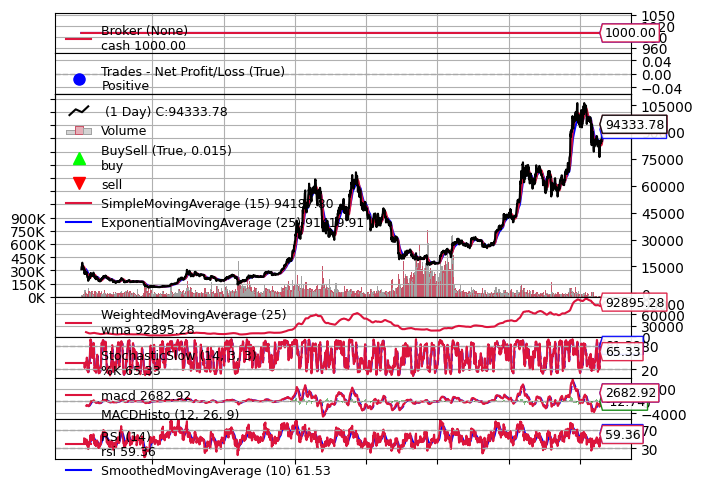

[[<Figure size 640x480 with 8 Axes>]]

In [14]:
#specify iplot=False to display the image inline :)
cerebro.plot(iplot=False, figsize=(18, 9))

#### Optimization
 We pass a set of MA period to see which one will give us the best performace!

In [15]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

import datetime  # For datetime objects
import os.path  # To manage paths
import sys  # To find out the script name (in argv[0])


# Import the backtrader platform
import backtrader as bt


# Create a Stratey
class TestStrategy(bt.Strategy):
    params = (
        ('maperiod', 15),
        ('printlog', False),
    )

    def log(self, txt, dt=None, doprint=False):
        ''' Logging function fot this strategy'''
        if self.params.printlog or doprint:
            dt = dt or self.datas[0].datetime.date(0)
            print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close

        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None

        # Add a MovingAverageSimple indicator
        self.sma = bt.indicators.SimpleMovingAverage(
            self.datas[0], period=self.params.maperiod)

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))

    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f' % self.dataclose[0])

        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

        # Check if we are in the market
        if not self.position:

            # Not yet ... we MIGHT BUY if ...
            if self.dataclose[0] > self.sma[0]:

                # BUY, BUY, BUY!!! (with all possible default parameters)
                self.log('BUY CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.buy()

        else:

            if self.dataclose[0] < self.sma[0]:
                # SELL, SELL, SELL!!! (with all possible default parameters)
                self.log('SELL CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell()

    def stop(self):
        self.log('(MA Period %2d) Ending Value %.2f' %
                 (self.params.maperiod, self.broker.getvalue()), doprint=True)


if __name__ == '__main__':
    # Create a cerebro entity
    cerebro = bt.Cerebro()

    # Add a strategy
    strats = cerebro.optstrategy(
        TestStrategy,
        maperiod=range(10, 31))

    # Datas are in a subfolder of the samples. Need to find where the script is
    # because it could have been called from anywhere
    modpath = os.path.dirname(os.path.abspath(sys.argv[0]))
    datapath = os.path.join(modpath, '../../datas/orcl-1995-2014.txt')

    # Create a Data Feed
    data =  pd.read_csv(path + 'btc_1d_data_2018_to_2025.csv')[['Open time', 'Open', 'High', 'Low', 'Close', 'Volume']]
    data['Open time'] = pd.to_datetime(data['Open time'])
    data.set_index('Open time', inplace=True)
    data.rename(columns={
    'Open': 'open',
    'High': 'high',
    'Low': 'low',
    'Close': 'close',
    'Volume': 'volume'
    }, inplace=True)
    data = bt.feeds.PandasData(dataname=data)

    # Add the Data Feed to Cerebro
    cerebro.adddata(data)

    # Set our desired cash start
    cerebro.broker.setcash(1000.0)

    # Add a FixedSize sizer according to the stake
    cerebro.addsizer(bt.sizers.FixedSize, stake=10)

    # Set the commission
    cerebro.broker.setcommission(commission=0.0)

    # Run over everything
    cerebro.run(maxcpus=1)

2025-05-06, (MA Period 10) Ending Value 1000.00
2025-05-06, (MA Period 11) Ending Value 1000.00
2025-05-06, (MA Period 12) Ending Value 1000.00
2025-05-06, (MA Period 13) Ending Value 1000.00
2025-05-06, (MA Period 14) Ending Value 1000.00
2025-05-06, (MA Period 15) Ending Value 1000.00
2025-05-06, (MA Period 16) Ending Value 1000.00
2025-05-06, (MA Period 17) Ending Value 1000.00
2025-05-06, (MA Period 18) Ending Value 1000.00
2025-05-06, (MA Period 19) Ending Value 1000.00
2025-05-06, (MA Period 20) Ending Value 1000.00
2025-05-06, (MA Period 21) Ending Value 1000.00
2025-05-06, (MA Period 22) Ending Value 1000.00
2025-05-06, (MA Period 23) Ending Value 1000.00
2025-05-06, (MA Period 24) Ending Value 1000.00
2025-05-06, (MA Period 25) Ending Value 1000.00
2025-05-06, (MA Period 26) Ending Value 1000.00
2025-05-06, (MA Period 27) Ending Value 1000.00
2025-05-06, (MA Period 28) Ending Value 1000.00
2025-05-06, (MA Period 29) Ending Value 1000.00
2025-05-06, (MA Period 30) Ending Value 

### Crossing MAs Strategy

#### Importing Libraries and Data

In [16]:
!pip install backtrader

In [17]:
#DATA saved locally for testing to limit yf API usage
from google.colab import drive
import os
import pandas as pd
drive.mount('/content/drive')
path = "/content/drive/My Drive/QUANT/DATA/"
print("Files in project folder:", os.listdir(path))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Files in project folder: ['btc_1d_data_2018_to_2025.csv', 'btc_1h_data_2018_to_2025.csv']


#### Plotting MAs

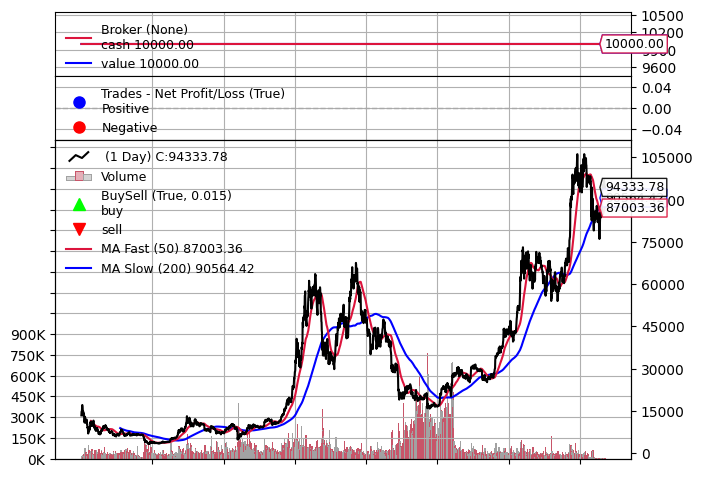

[[<Figure size 640x480 with 4 Axes>]]

In [18]:
import backtrader as bt
import pandas as pd
import datetime as dt
import yfinance as yf

#--- DEFINE THE STRATEGY ---#
class Test1(bt.Strategy):
#define the moving averages
  def __init__(self):
    self.ma_fast = bt.ind.SMA(self.data.close, period=50, plotname='MA Fast')
    self.ma_slow = bt.ind.SMA(self.data.close, period=200, plotname='MA Slow')


#create an instance of the Cerebro class
cerebro = bt.Cerebro()

#feed data into bt
data =  pd.read_csv(path + 'btc_1d_data_2018_to_2025.csv')[['Open time', 'Open', 'High', 'Low', 'Close', 'Volume']]
data['Open time'] = pd.to_datetime(data['Open time'])
data.set_index('Open time', inplace=True)
data.rename(columns={
    'Open': 'open',
    'High': 'high',
    'Low': 'low',
    'Close': 'close',
    'Volume': 'volume'
}, inplace=True)
data = bt.feeds.PandasData(dataname=data)
cerebro.adddata(data)

#add strategy
cerebro.addstrategy(Test1)
#run
cerebro.run()
cerebro.plot(iplot=False, figsize=(30, 15))

#### Base Strategy - Crossing MAs

In [19]:
import backtrader as bt
import pandas as pd
import datetime as dt
import yfinance as yf

#--- DEFINE THE STRATEGY ---#
class Test1(bt.Strategy):

#attributes definition
  def __init__(self):
    #fast and slow MAs
    self.ma_fast = bt.ind.SMA(self.data.close, period=50, plotname='MA Fast')
    self.ma_slow = bt.ind.SMA(self.data.close, period=200, plotname='MA Slow')
    #positioning indicator
    self.crossover = bt.ind.CrossOver(self.ma_fast, self.ma_slow)
    #keep track of pending orders
    self.order = None

#logging method
  def log(self, txt, dt=None):
    ''' Logging function for this strategy'''
    dt = dt or self.datas[0].datetime.date(0)
    print(f'{dt} {txt}')

#order notification
  def notify_order(self, order):
    #buy/sell order submitted/accepted to/by broker -> nothing to do!
    if order.status in [order.Submitted, order.Accepted]:
      return
    #buy/sell order is completed to/by broker -> than notify!
    if order.status in [order.Completed]:
      if order.isbuy():
        self.log(f'BUY EXECUTED, Price: {round(order.executed.price,2)}, Size {round(order.executed.size,2)}')
      elif order.issell():
        self.log(f'SELL EXECUTED, Price: {round(order.executed.price,2)}, Size {round(order.executed.size,2)}')
    elif order.status in [order.Canceled, order.Margin, order.Rejected]:
      self.log('Order Canceled/Margin/Rejected')
    #reset order tracker
    self.order = None

#trade notification
  def notify_trade(self, trade):
    if trade.isclosed:
      self.log(f'OPERATION PROFIT, GROSS {round(trade.pnl,2)}, NET {round(trade.pnlcomm,2)}')

  def next(self):
    #wait previous order to be processed
    if self.order:
      return
    if not self.position:
      if self.crossover > 0:
        self.log(f'BUY CREATED, Price: {round(self.data.close[0],2)}')
        self.order = self.buy()
    else:
      if self.crossover < 0:
        self.log(f'SELL CREATED, Price: {round(self.data.close[0],2)}')
        self.order = self.sell()

#
#create an instance of the Cerebro class
cerebro = bt.Cerebro()
#feed data into bt
data =  pd.read_csv(path + 'btc_1d_data_2018_to_2025.csv')[['Open time', 'Open', 'High', 'Low', 'Close', 'Volume']]
data['Open time'] = pd.to_datetime(data['Open time'])
data.set_index('Open time', inplace=True)
data.rename(columns={
    'Open': 'open',
    'High': 'high',
    'Low': 'low',
    'Close': 'close',
    'Volume': 'volume'
}, inplace=True)
data = bt.feeds.PandasData(dataname=data)
cerebro.adddata(data)
#add strategy
cerebro.addstrategy(Test1)
#add cash and broker commission
cerebro.broker.setcash(100000.0)
cerebro.broker.setcommission(commission=0.001)
#run
cerebro.run()


2019-04-24 BUY CREATED, Price: 5415.0
2019-04-25 BUY EXECUTED, Price: 5415.0, Size 1
2019-10-26 SELL CREATED, Price: 9230.0
2019-10-27 SELL EXECUTED, Price: 9230.0, Size -1
2019-10-27 OPERATION PROFIT, GROSS 3815.0, NET 3800.36
2020-02-18 BUY CREATED, Price: 10164.71
2020-02-19 BUY EXECUTED, Price: 10164.78, Size 1
2020-03-25 SELL CREATED, Price: 6677.43
2020-03-26 SELL EXECUTED, Price: 6677.42, Size -1
2020-03-26 OPERATION PROFIT, GROSS -3487.36, NET -3504.2
2020-05-21 BUY CREATED, Price: 9068.65
2020-05-22 BUY EXECUTED, Price: 9067.51, Size 1
2021-06-19 SELL CREATED, Price: 35483.72
2021-06-20 SELL EXECUTED, Price: 35483.72, Size -1
2021-06-20 OPERATION PROFIT, GROSS 26416.21, NET 26371.66
2021-09-15 BUY CREATED, Price: 48121.41
2021-09-16 BUY EXECUTED, Price: 48121.4, Size 1
2022-01-14 SELL CREATED, Price: 43059.96
2022-01-15 SELL EXECUTED, Price: 43059.96, Size -1
2022-01-15 OPERATION PROFIT, GROSS -5061.44, NET -5152.62
2023-02-07 BUY CREATED, Price: 23240.46
2023-02-08 BUY EXECUT

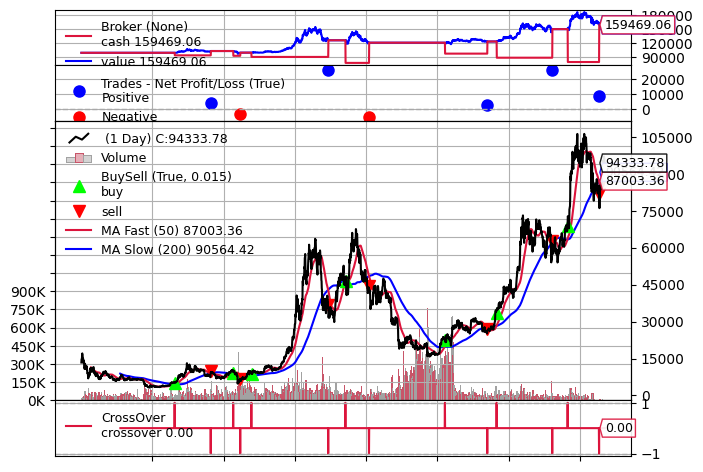

[[<Figure size 640x480 with 5 Axes>]]

In [20]:
cerebro.plot(iplot=False, figsize=(30, 15))

#### Adding Sizers

##### Percentage Sizer (95% of liquidity)

Starting Value: 100000.00
2019-04-24 BUY CREATED, Price: 5415.0
2019-04-25 BUY EXECUTED, Price: 5415.0, Size 17.54
2019-10-26 SELL CREATED, Price: 9230.0
2019-10-27 SELL EXECUTED, Price: 9230.0, Size -17.54
2019-10-27 OPERATION PROFIT, GROSS 66929.82, NET 66672.89
2020-02-18 BUY CREATED, Price: 10164.71
2020-02-19 BUY EXECUTED, Price: 10164.78, Size 15.58
2020-03-25 SELL CREATED, Price: 6677.43
2020-03-26 SELL EXECUTED, Price: 6677.42, Size -15.58
2020-03-26 OPERATION PROFIT, GROSS -54323.83, NET -54586.19
2020-05-21 BUY CREATED, Price: 9068.65
2020-05-22 BUY EXECUTED, Price: 9067.51, Size 11.74
2021-06-19 SELL CREATED, Price: 35483.72
2021-06-20 SELL EXECUTED, Price: 35483.72, Size -11.74
2021-06-20 OPERATION PROFIT, GROSS 310174.14, NET 309651.03
2021-09-15 BUY CREATED, Price: 48121.41
2021-09-16 BUY EXECUTED, Price: 48121.4, Size 8.33
2022-01-14 SELL CREATED, Price: 43059.96
2022-01-15 SELL EXECUTED, Price: 43059.96, Size -8.33
2022-01-15 OPERATION PROFIT, GROSS -42140.71, NET -4289

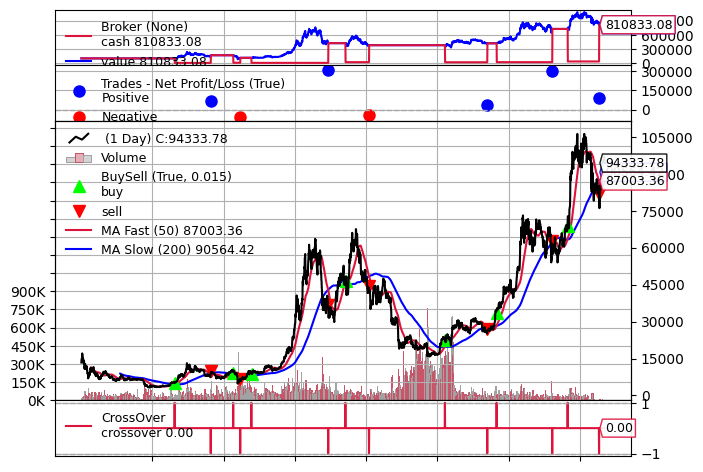

[[<Figure size 640x480 with 5 Axes>]]

In [21]:
import backtrader as bt
import pandas as pd
import datetime as dt
import yfinance as yf

#--- DEFINE THE STRATEGY ---#
class Test1(bt.Strategy):

#attributes definition
  def __init__(self):
    #fast and slow MAs
    self.ma_fast = bt.ind.SMA(self.data.close, period=50, plotname='MA Fast')
    self.ma_slow = bt.ind.SMA(self.data.close, period=200, plotname='MA Slow')
    #positioning indicator
    self.crossover = bt.ind.CrossOver(self.ma_fast, self.ma_slow)
    #keep track of pending orders
    self.order = None

#logging method
  def log(self, txt, dt=None):
    ''' Logging function for this strategy'''
    dt = dt or self.datas[0].datetime.date(0)
    print(f'{dt} {txt}')

#order notification
  def notify_order(self, order):
    #buy/sell order submitted/accepted to/by broker -> nothing to do!
    if order.status in [order.Submitted, order.Accepted]:
      return
    #buy/sell order is completed to/by broker -> than notify!
    if order.status in [order.Completed]:
      if order.isbuy():
        self.log(f'BUY EXECUTED, Price: {round(order.executed.price,2)}, Size {round(order.executed.size,2)}')
      elif order.issell():
        self.log(f'SELL EXECUTED, Price: {round(order.executed.price,2)}, Size {round(order.executed.size,2)}')
    elif order.status in [order.Canceled, order.Margin, order.Rejected]:
      self.log('Order Canceled/Margin/Rejected')
    #reset order tracker
    self.order = None

#trade notification
  def notify_trade(self, trade):
    if trade.isclosed:
      self.log(f'OPERATION PROFIT, GROSS {round(trade.pnl,2)}, NET {round(trade.pnlcomm,2)}')

  def next(self):
    #wait previous order to be processed
    if self.order:
      return
    if not self.position:
      if self.crossover > 0:
        self.log(f'BUY CREATED, Price: {round(self.data.close[0],2)}')
        self.order = self.buy()
    else:
      if self.crossover < 0:
        self.log(f'SELL CREATED, Price: {round(self.data.close[0],2)}')
        self.order = self.sell()

#
#create an instance of the Cerebro class
cerebro = bt.Cerebro()
#feed data into bt
data =  pd.read_csv(path + 'btc_1d_data_2018_to_2025.csv')[['Open time', 'Open', 'High', 'Low', 'Close', 'Volume']]
data['Open time'] = pd.to_datetime(data['Open time'])
data.set_index('Open time', inplace=True)
data.rename(columns={
    'Open': 'open',
    'High': 'high',
    'Low': 'low',
    'Close': 'close',
    'Volume': 'volume'
}, inplace=True)
data = bt.feeds.PandasData(dataname=data)
cerebro.adddata(data)
#add strategy
cerebro.addstrategy(Test1)
#add cash and broker commission
cerebro.broker.setcash(100000.0)
cerebro.broker.setcommission(commission=0.001)
#we can simply add a sizer as a percentage of the available cash
cerebro.addsizer(bt.sizers.PercentSizer, percents=95) #use 95% of the liquidity

#run
print('Starting Value: %.2f' % cerebro.broker.getvalue())
#run the backtest
cerebro.run()
print('Final Value: %.2f' % cerebro.broker.getvalue())

#plot
cerebro.plot(iplot=False)

##### Volatility-Based Position Sizing (ATR)

- We change the timeframe to 1h
- We add a custom sizer for a short timeframe trading

Starting Value: 1000000.00
2024-01-27 BUY CREATED, Price: 41470.01
2024-01-27 BUY EXECUTED, Price: 41470.01, Size 22
2024-02-05 SELL CREATED, Price: 42708.7
2024-02-06 SELL EXECUTED, Price: 42708.7, Size -22
2024-02-06 OPERATION PROFIT, GROSS 27251.18, NET 25399.25
2024-02-07 BUY CREATED, Price: 43499.91
2024-02-07 BUY EXECUTED, Price: 43499.91, Size 22
2024-02-22 SELL CREATED, Price: 51418.36
2024-02-22 SELL EXECUTED, Price: 51418.37, Size -22
2024-02-22 OPERATION PROFIT, GROSS 174206.12, NET 172117.92
2024-02-26 BUY CREATED, Price: 53391.02
2024-02-26 BUY EXECUTED, Price: 53391.01, Size 17
2024-03-16 SELL CREATED, Price: 68984.91
2024-03-16 SELL EXECUTED, Price: 68984.91, Size -17
2024-03-16 OPERATION PROFIT, GROSS 265096.3, NET 263015.91
2024-03-25 BUY CREATED, Price: 67079.99
2024-03-25 BUY EXECUTED, Price: 67079.99, Size 14
2024-04-02 SELL CREATED, Price: 66764.65
2024-04-02 SELL EXECUTED, Price: 66764.64, Size -14
2024-04-02 OPERATION PROFIT, GROSS -4414.9, NET -6288.72
2024-04-0

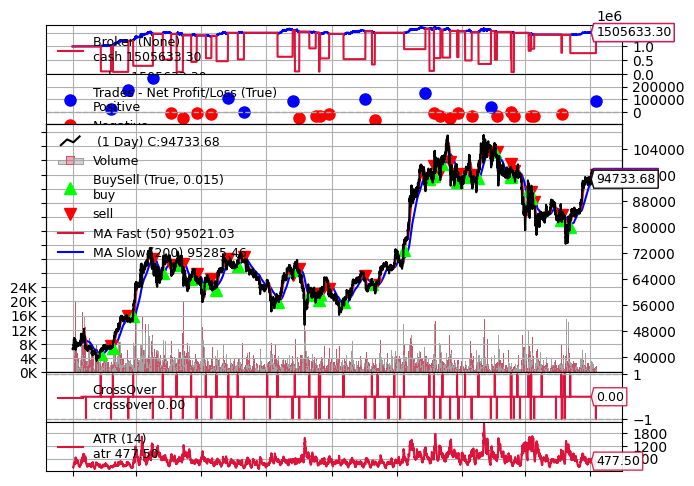

[[<Figure size 640x480 with 6 Axes>]]

In [39]:
import backtrader as bt
import pandas as pd
import datetime as dt
import yfinance as yf

#--- DEFINE THE TRADING STRATEGY ---#
class Test1(bt.Strategy):
  #strategy parameters
  params =dict(
        ma_fast=50,
        ma_slow=200,
            )
#attributes definition
  def __init__(self):
    #fast and slow MAs
    self.ma_fast = bt.ind.SMA(self.data.close, period=self.p.ma_fast, plotname='MA Fast')
    self.ma_slow = bt.ind.SMA(self.data.close, period=self.p.ma_slow, plotname='MA Slow')
    #positioning indicator
    self.crossover = bt.ind.CrossOver(self.ma_fast, self.ma_slow)
    #keep track of pending orders
    self.order = None

#logging method
  def log(self, txt, dt=None):
    ''' Logging function for this strategy'''
    dt = dt or self.datas[0].datetime.date(0)
    print(f'{dt} {txt}')

#order notification
  def notify_order(self, order):
    #buy/sell order submitted/accepted to/by broker -> nothing to do!
    if order.status in [order.Submitted, order.Accepted]:
      return
    #buy/sell order is completed to/by broker -> than notify!
    if order.status in [order.Completed]:
      if order.isbuy():
        self.log(f'BUY EXECUTED, Price: {round(order.executed.price,2)}, Size {round(order.executed.size,2)}')
      elif order.issell():
        self.log(f'SELL EXECUTED, Price: {round(order.executed.price,2)}, Size {round(order.executed.size,2)}')
    elif order.status in [order.Canceled, order.Margin, order.Rejected]:
      self.log('Order Canceled/Margin/Rejected')
    #reset order tracker
    self.order = None

#trade notification
  def notify_trade(self, trade):
    if trade.isclosed:
      self.log(f'OPERATION PROFIT, GROSS {round(trade.pnl,2)}, NET {round(trade.pnlcomm,2)}')

  def next(self):
    #wait previous order to be processed
    if self.order:
      return
    if not self.position:
      if self.crossover > 0:
        self.log(f'BUY CREATED, Price: {round(self.data.close[0],2)}')
        self.order = self.buy()
    else:
      if self.crossover < 0:
        self.log(f'SELL CREATED, Price: {round(self.data.close[0],2)}')
        self.order = self.sell()



#--- DEFINE THE POSITION SIZING STRATEGY ---#
class ATR_Sizer(bt.Sizer):
    params = dict(atr_period = 14, risk_per_trade = 0.01, atr_mult = 2)

    def __init__(self):
      self.atr = bt.ind.ATR(data, period=self.p.atr_period)

    def _getsizing(self, comminfo, cash, data, isbuy):
      #make sure ATR has enough data to return a valid value
      if len(data) < self.p.atr_period or self.atr[0] == 0:
        return 0
      #if we close a long return the current position size so bt closes it
      if not isbuy:
        return self.broker.getposition(data).size
      #calculate stop-loss distance
      stop_loss = self.atr[0] * self.p.atr_mult
      if stop_loss == 0:
        return 0

      # calculate the dollar risk and position size
      portfolio_value = self.broker.getvalue()
      risk_amount = self.p.risk_per_trade * portfolio_value
      size = risk_amount / stop_loss

      # make sure size is an integer
      return int(size)


#create an instance of the Cerebro class
cerebro = bt.Cerebro()
#feed data into bt
data =  pd.read_csv(path + 'btc_1h_data_2018_to_2025.csv')[['Open time', 'Open', 'High', 'Low', 'Close', 'Volume']]
data['Open time'] = pd.to_datetime(data['Open time'])
data.set_index('Open time', inplace=True)
data.rename(columns={
    'Open': 'open',
    'High': 'high',
    'Low': 'low',
    'Close': 'close',
    'Volume': 'volume'
}, inplace=True)
data = data.loc['2024-01-01':] #filerinng only 1 year
data = bt.feeds.PandasData(dataname=data)
cerebro.adddata(data)
#add strategy
cerebro.addstrategy(Test1)
#add cash and broker commission
cerebro.broker.setcash(1000000.0)
cerebro.broker.setcommission(commission=0.001)
#we can simply add a sizer as a percentage of the available cash

#cerebro.addsizer(bt.sizers.PercentSizer, percents=95) #use 95% of the liquidity
cerebro.addsizer(ATR_Sizer)
#run
print('Starting Value: %.2f' % cerebro.broker.getvalue())
#run the backtest
cerebro.run()
print('Final Value: %.2f' % cerebro.broker.getvalue())

#plot
cerebro.plot(iplot=False)